In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler



In [2]:
df = pd.read_csv('data/Traffic.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [3]:
df.shape
#Get date range
print('Start date:', df['Date'].min())
print('End date:', df['Date'].max())



Start date: 1
End date: 31


In [4]:
import pandas as pd
import numpy as np

# Convert 'Time' to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.time

# Encode hours as sine and cosine
df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df.drop(columns=['Time', 'hour'], inplace=True)  # Drop original 'Time' column


In [5]:
df = pd.get_dummies(df, columns=['Day of the week'], drop_first=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Traffic Situation'] = label_encoder.fit_transform(df['Traffic Situation'])
df = pd.get_dummies(df, columns=['Traffic Situation'], drop_first=True)



In [7]:
lags = 3  # Number of lag steps to include
for i in range(1, lags + 1):
    df[f'Total_lag_{i}'] = df['Total'].shift(i)

df.dropna(inplace=True)  # Drop rows with NaN values created by lagging



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total'] + \
                     [f'Total_lag_{i}' for i in range(1, lags + 1)] + \
                     ['hour_sin', 'hour_cos']
df[numerical_features] = scaler.fit_transform(df[numerical_features])




In [9]:
X = df.drop(columns=['Total']).values
y = df['Total'].values




In [10]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])  # Sequence of time_steps
        y_seq.append(y[i + time_steps])  # Target is the next step
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)



In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)






In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [28]:
from tensorflow.keras.layers import Bidirectional, LeakyReLU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
model2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)), 
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0734 - mae: 0.2179 - val_loss: 0.0203 - val_mae: 0.1071 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0231 - mae: 0.1149 - val_loss: 0.0215 - val_mae: 0.1105 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0195 - mae: 0.1065 - val_loss: 0.0176 - val_mae: 0.1001 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0170 - mae: 0.1001 - val_loss: 0.0152 - val_mae: 0.0930 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0178 - mae: 0.0998 - val_loss: 0.0152 - val_mae: 0.0902 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0164 - mae: 0.0961 - val_loss: 0.0147 - val_mae: 0.0894 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0149 - mae: 0.0900 - val_loss: 0.0149 - val_mae: 0.0881 - learning_rate: 0.0010
Epoch 8/50
75

In [70]:
# Evaluate the model on the test dataset
loss, mae = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae:.4f}")
print(f"Test Loss: {loss:.4f}")




19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - mae: 0.0830
Test MAE: 0.0800
Test Loss: 0.0123


In [71]:
# Step 1: Generate Predictions
y_pred = model2.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}") 


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R^2 Score: 0.7680


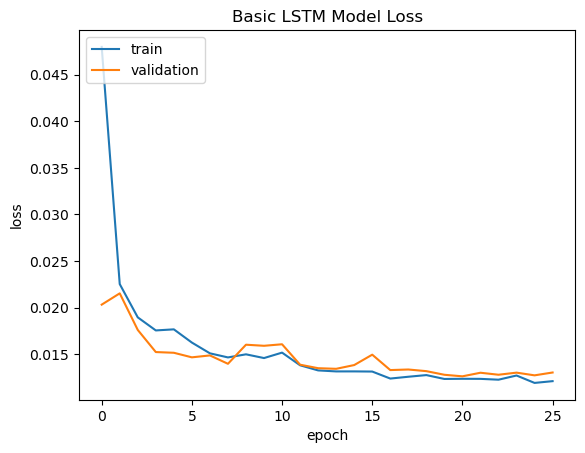

In [31]:
#plot training
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Basic LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


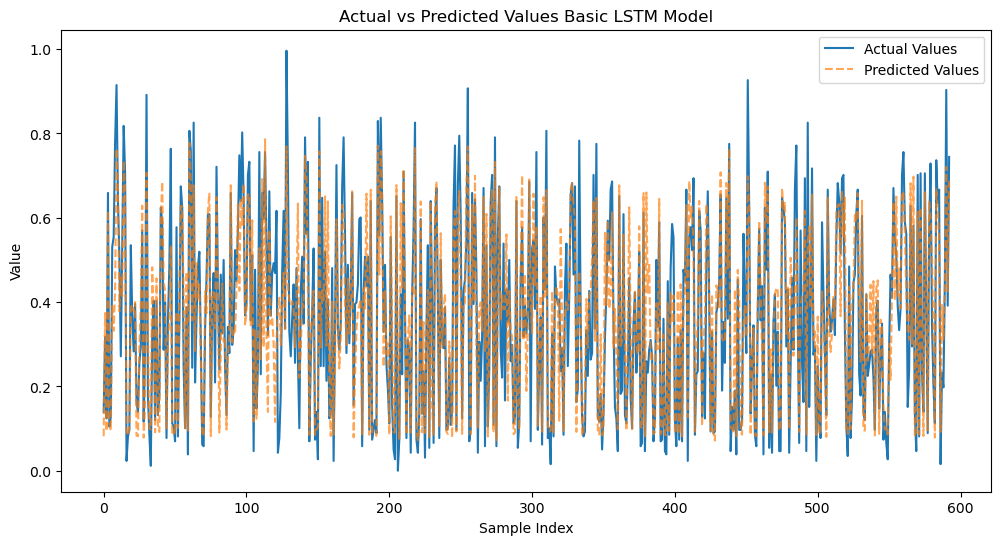

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model2.predict(X_test)

# Plot the actual vs predicted values as overlapping lines
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values Basic LSTM Model')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [33]:
from tensorflow.keras.layers import Bidirectional, LeakyReLU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
model2_batch = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)), 
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1)
])

model2_batch.compile(optimizer='adam', loss='mse', metrics=['mae']) 

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history2_batch = model2_batch.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2301 - mae: 0.3703 - val_loss: 0.1260 - val_mae: 0.2826 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0564 - mae: 0.1887 - val_loss: 0.1060 - val_mae: 0.2564 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0439 - mae: 0.1679 - val_loss: 0.0696 - val_mae: 0.2042 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0338 - mae: 0.1441 - val_loss: 0.0497 - val_mae: 0.1746 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0301 - mae: 0.1359 - val_loss: 0.0326 - val_mae: 0.1432 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0252 - mae: 0.1214 - val_loss: 0.0247 - val_mae: 0.1225 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0239 - mae: 0.1189 - val_loss: 0.0175 - val_mae: 0.1008 - learning_rate: 0.0010
Epoch 8/50
75

In [15]:
# Evaluate the model on the test dataset
loss, mae = model2_batch.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae:.4f}")
print(f"Test Loss: {loss:.4f}")
# Step 1: Generate Predictions
y_pred = model2_batch.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}") 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - mae: 0.0880
Test MAE: 0.0854
Test Loss: 0.0137
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
R^2 Score: 0.7403


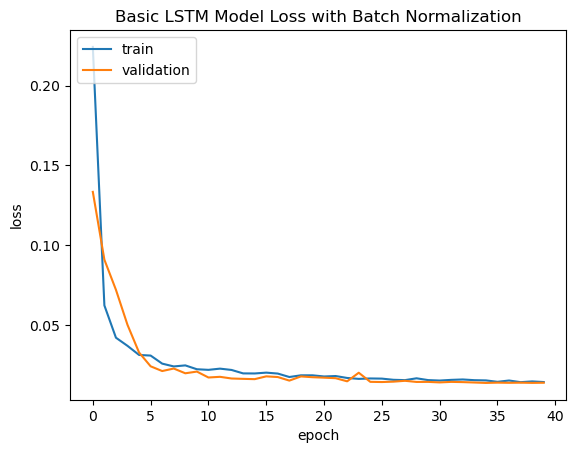

In [30]:
#plot training
plt.plot(history2_batch.history['loss'])
plt.plot(history2_batch.history['val_loss'])
plt.title('Basic LSTM Model Loss with Batch Normalization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


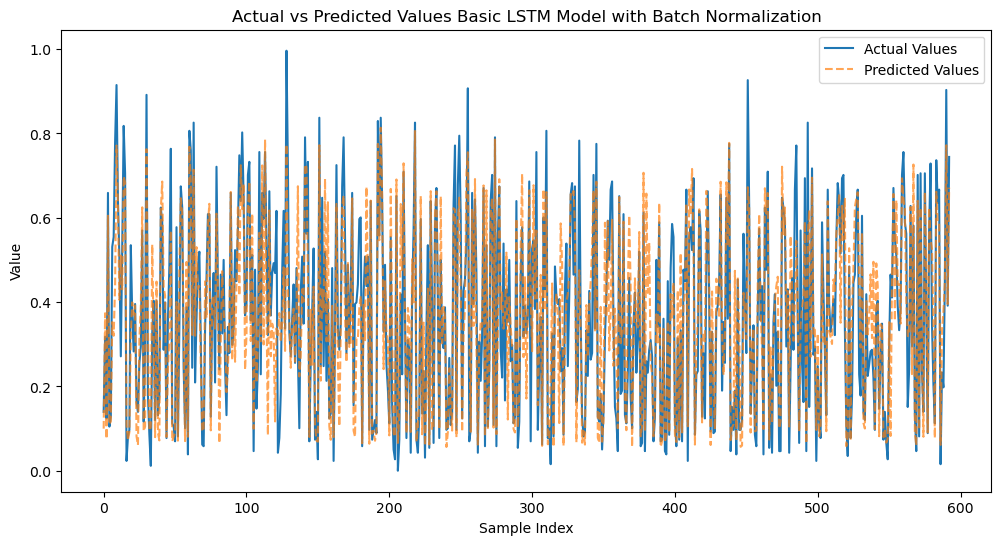

In [35]:

y_pred = model2_batch.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values Basic LSTM Model with Batch Normalization')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [21]:
from tensorflow.keras.layers import Bidirectional, LeakyReLU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
model2_l2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))), 
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(32, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.01),
    Dense(1)
])

model2_l2.compile(optimizer='adam', loss='mse', metrics=['mae']) 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history2_l2 = model2_l2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 6.2947 - mae: 0.3884 - val_loss: 2.9284 - val_mae: 0.3153 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.3151 - mae: 0.1816 - val_loss: 1.3328 - val_mae: 0.2824 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.0676 - mae: 0.1534 - val_loss: 0.7301 - val_mae: 0.2455 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.5826 - mae: 0.1387 - val_loss: 0.4444 - val_mae: 0.2229 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.3494 - mae: 0.1303 - val_loss: 0.2897 - val_mae: 0.2051 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.2263 - mae: 0.1300 - val_loss: 0.1982 - val_mae: 0.1849 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1492 - mae: 0.1172 - val_loss: 0.1381 - val_mae: 0.1658 - learning_rate: 0.0010
Epoch 8/50
75

In [23]:
# Evaluate the model on the test dataset
loss, mae = model2_l2.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae:.4f}")
print(f"Test Loss: {loss:.4f}")
# Step 1: Generate Predictions
y_pred = model2_l2.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}") 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160 - mae: 0.0870
Test MAE: 0.0831
Test Loss: 0.0148
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R^2 Score: 0.7590


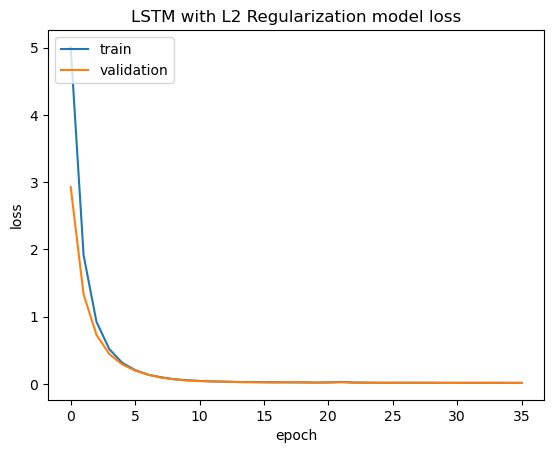

In [27]:
#plot training
plt.plot(history2_l2.history['loss'])
plt.plot(history2_l2.history['val_loss'])
plt.title('LSTM with L2 Regularization model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


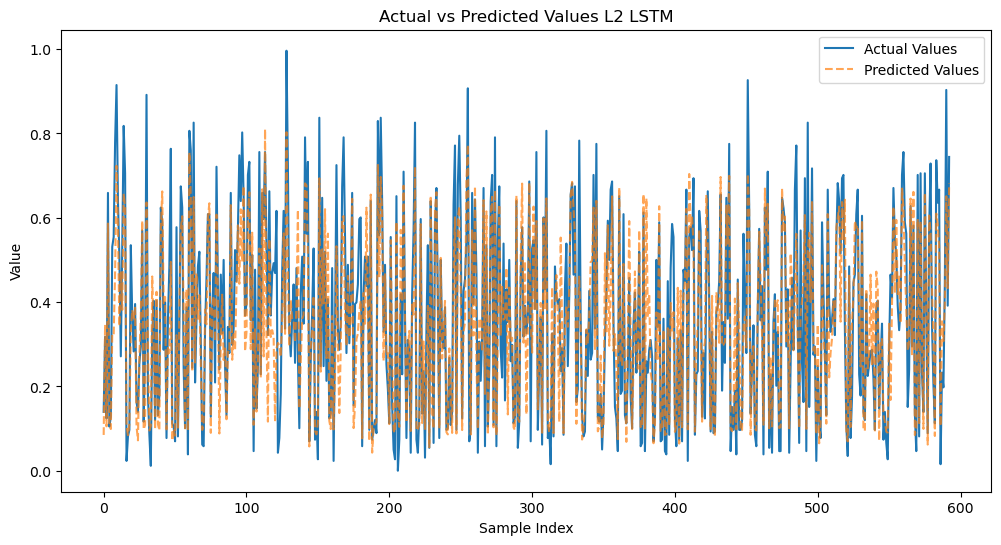

In [26]:

y_pred = model2_l2.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values L2 LSTM')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
#RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, Dropout, LayerNormalization, LeakyReLU, Input
from tensorflow.keras.layers import SimpleRNNCell

model3 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  
    RNN(SimpleRNNCell(128), return_sequences=True),
    LeakyReLU(alpha=0.01),  
    Dropout(0.3),
    RNN(SimpleRNNCell(128), return_sequences=True),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    RNN(SimpleRNNCell(64)),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(alpha= 0.01),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1)  
])

model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)
loss, mae = model3.evaluate(X_test, y_test, verbose=1)
print(f"RNN Validation Loss: {loss}")
print(f"RNN Validation MAE: {mae}")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0911 - mae: 0.2466 - val_loss: 0.0520 - val_mae: 0.1910 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0531 - mae: 0.1954 - val_loss: 0.0314 - val_mae: 0.1379 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0378 - mae: 0.1566 - val_loss: 0.0540 - val_mae: 0.1828 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0355 - mae: 0.1517 - val_loss: 0.0224 - val_mae: 0.1146 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - mae: 0.1260 - val_loss: 0.0353 - val_mae: 0.1474 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0295 - mae: 0.1372 - val_loss: 0.0208 - val_mae: 0.1142 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0251 - mae: 0.1255 - val_loss: 0.0263 - val_mae: 0.1217 - learning_rate: 0.0010
Epoch 8/50
75/75 ━━━

In [76]:
#r2 score
y_pred = model3.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R^2 Score: 0.7221


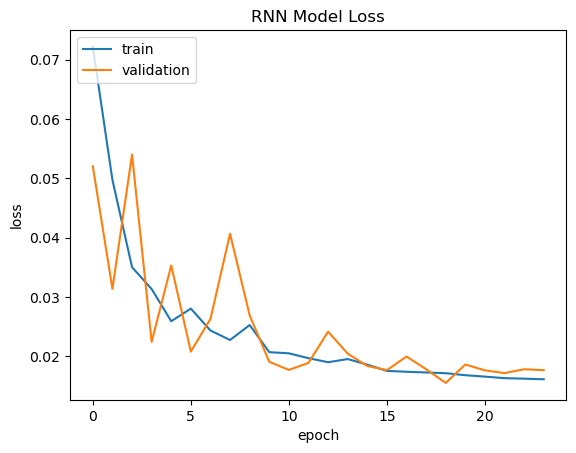

In [38]:
#plot training
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


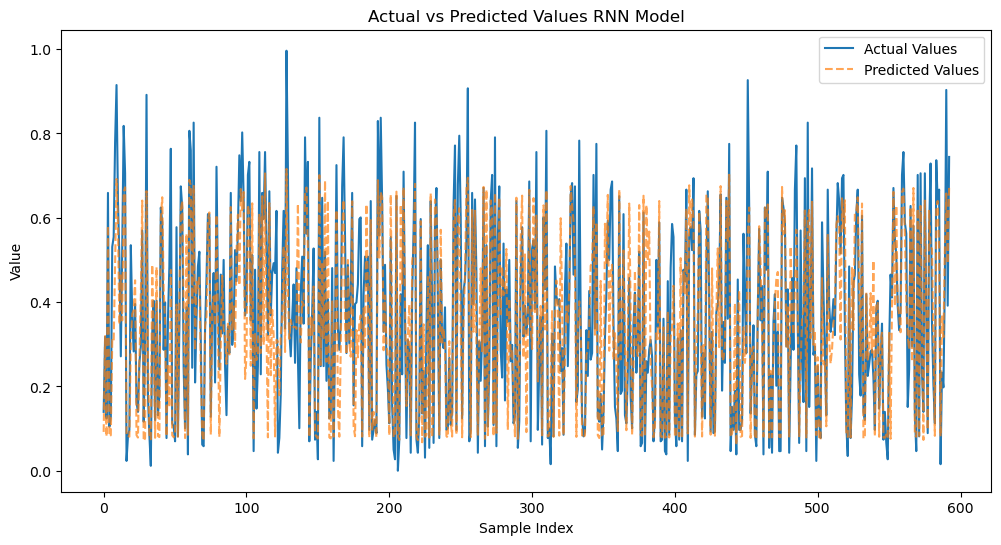

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model3.predict(X_test)

# Plot the actual vs predicted values as overlapping lines
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values RNN Model')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [1]:
import os
#convert to html
os.system('jupyter nbconvert --to html Congestion_Prediction.ipynb')

[NbConvertApp] Converting notebook Congestion_Prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 2214036 bytes to Congestion_Prediction.html


0